In [9]:
import fnmatch
import glob
import os
import re
from time import sleep
from zipfile import ZipFile

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from utils.near_regex import * 
from tqdm import tqdm  
from sec_edgar_downloader import Downloader
from requests_html import HTMLSession
import shutil

os.makedirs("output", exist_ok=True)

In [10]:
#load in the s&p 500 data csv
sp500_file = 'inputs/sp500_2022.csv'

# get it if we haven't 
if not os.path.exists(sp500_file):
    # 2022 dec version of page
    url = 'https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&oldid=1130173030'
    pd.read_html(url)[0].to_csv(sp500_file,index=False)

# load and look at it
sp500 = pd.read_csv(sp500_file)    

In [11]:
dl = Downloader("Evan Trock", 
                "ert226@lehigh.edu",
                "10k_files")

In [12]:
if not os.path.exists('10k_files/10k_files.zip'):
    
    for cik in tqdm(sp500['CIK'][:503]):
         
        firm_folder = f'10k_files/sec-edgar-filings/{str(cik).zfill(10)}/'  # str(cik).zfill(10)   means that CIK 1234 becomes 0000001234

        # if I haven't downloaded any HTML for this firm (len=0 files on this pattern), do so
        # you could make this more precise and only look for filings during 2022 (if you were downloading across many years)
        
        if len(glob.glob(firm_folder + '/10-K/*/*.html')) == 0:
            
            dl.get("10-K", cik, 
                   limit=1,                  # get the latest filing within window
                   after="2022-01-01",       # does this download filings ON 1/1 or nah? (check)
                   before="2022-12-31",      # does this download filings ON 12/31 or nah? (check)
                   download_details =True    # download the html 
            ) 
    
        # delete the txt files as we go!!!
        # files are of the form: folder/10-K/*/*.txt
        for txt_f in glob.glob(firm_folder + '/10-K/*/*.txt'):
            os.remove(txt_f) 

100%|██████████| 503/503 [05:53<00:00,  1.42it/s]


In [13]:
files = glob.glob('10k_files/sec-edgar-filings/*/10-K/*/*.html')
files = [file.replace('\\', '/') for file in files]
#f'We have {len(files)} HTML files for {len(sp500["CIK"])} firms'
files

['10k_files/sec-edgar-filings/0000001800/10-K/0001104659-22-025141/primary-document.html',
 '10k_files/sec-edgar-filings/0000002488/10-K/0000002488-22-000016/primary-document.html',
 '10k_files/sec-edgar-filings/0000002969/10-K/0000002969-22-000054/primary-document.html',
 '10k_files/sec-edgar-filings/0000004127/10-K/0000004127-22-000038/primary-document.html',
 '10k_files/sec-edgar-filings/0000004281/10-K/0000004281-22-000004/primary-document.html',
 '10k_files/sec-edgar-filings/0000004447/10-K/0001628280-22-004524/primary-document.html',
 '10k_files/sec-edgar-filings/0000004904/10-K/0000004904-22-000024/primary-document.html',
 '10k_files/sec-edgar-filings/0000004962/10-K/0000004962-22-000008/primary-document.html',
 '10k_files/sec-edgar-filings/0000004977/10-K/0000004977-22-000058/primary-document.html',
 '10k_files/sec-edgar-filings/0000005272/10-K/0001104659-22-024701/primary-document.html',
 '10k_files/sec-edgar-filings/0000006201/10-K/0000006201-22-000026/primary-document.html',

In [14]:
import re
from requests_html import HTMLSession

session = HTMLSession()
session.headers.update({'User-Agent':'Evan Trock ert226@lehigh.edu'})

new_df = []

for item in files:
    segment = item.split('/') # split the path into segments
    cik = segment[-4]  
    accession_number = segment[-2]       
    url = f'https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number}-index.html'
    sleep(.3)
    #print(url)  
    r = session.get(url)
    date = r.html.find('#contentDiv > div:nth-child(1) > div.formContent > div:nth-child(1) > div:nth-child(2)', first=True).text
    new_df.append({'cik': cik, 'accession_number': accession_number, 'File Date': date, 'url': url })
df = pd.DataFrame(new_df)
print(df)

    

            cik      accession_number   File Date  \
0    0000001800  0001104659-22-025141  2022-02-18   
1    0000002488  0000002488-22-000016  2022-02-03   
2    0000002969  0000002969-22-000054  2022-11-22   
3    0000004127  0000004127-22-000038  2022-11-23   
4    0000004281  0000004281-22-000004  2022-02-14   
..          ...                   ...         ...   
493  0001783180  0001783180-22-000010  2022-02-08   
494  0001792044  0001792044-22-000010  2022-02-28   
495  0001821825  0001821825-22-000002  2022-03-21   
496  0001841666  0001784031-22-000009  2022-02-22   
497  0001868275  0001868275-22-000020  2022-02-25   

                                                   url  
0    https://www.sec.gov/Archives/edgar/data/000000...  
1    https://www.sec.gov/Archives/edgar/data/000000...  
2    https://www.sec.gov/Archives/edgar/data/000000...  
3    https://www.sec.gov/Archives/edgar/data/000000...  
4    https://www.sec.gov/Archives/edgar/data/000000...  
..                   

In [15]:
print(sp500.columns)
print(df.columns)

Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded'],
      dtype='object')
Index(['cik', 'accession_number', 'File Date', 'url'], dtype='object')


In [16]:
sp500['CIK'] = sp500['CIK'].astype(str).str.zfill(10)
df['cik'] = df['cik'].astype(str).str.zfill(10)

# Perform inner merge
merged_df = pd.merge(sp500, df, left_on='CIK',right_on = 'cik', how='inner')
merged_df = merged_df.drop(columns=['cik', 'url', 'GICS Sector', 'GICS Sub-Industry', 'SEC filings', 'Headquarters Location', 'Date first added', 'Founded'])

merged_df


,Symbol,Security,CIK,accession_number,File Date
0,MMM,3M,0000066740,0000066740-22-000010,2022-02-09
1,AOS,A. O. Smith,0000091142,0000091142-22-000028,2022-02-11
2,ABT,Abbott,0000001800,0001104659-22-025141,2022-02-18
3,ABBV,AbbVie,0001551152,0001551152-22-000007,2022-02-18
4,ACN,Accenture,0001467373,0001467373-22-000295,2022-10-12
...,...,...,...,...,...
496,YUM,Yum! Brands,0001041061,0001041061-22-000009,2022-02-23
497,ZBRA,Zebra Technologies,0000877212,0000877212-22-000026,2022-02-10
498,ZBH,Zimmer Biomet,0001136869,0001564590-22-007160,2022-02-25
499,ZION,Zions Bancorporation,0000109380,0000109380-22-000072,2022-02-25


In [17]:
import pandas_market_calendars as mcal
import pandas as pd

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Convert 'File Date' to datetime
merged_df['File Date'] = pd.to_datetime(merged_df['File Date'], errors='coerce')

# General function to calculate the nth trading day after the file date
def get_nth_trading_day_after(date, n):
    if pd.isnull(date):
        return None
    # Get the NYSE trading schedule for a period after the file date
    schedule = nyse.schedule(start_date=date, end_date=date + pd.Timedelta(days=n*2))
    trading_days = schedule.index
    if len(trading_days) >= n + 1:  # Ensure there are at least n+1 trading days
        return trading_days[n].date()  # Return the nth trading day after the file date
    else:
        return None

# Apply the function to calculate the 3rd and 10th trading days
merged_df['3rd_day_after'] = merged_df['File Date'].apply(lambda date: get_nth_trading_day_after(date, 3))
merged_df['10th_day_after'] = merged_df['File Date'].apply(lambda date: get_nth_trading_day_after(date, 10))

# Display the updated DataFrame
merged_df

,Symbol,Security,CIK,accession_number,File Date,3rd_day_after,10th_day_after
0,MMM,3M,0000066740,0000066740-22-000010,2022-02-09,2022-02-14,2022-02-24
1,AOS,A. O. Smith,0000091142,0000091142-22-000028,2022-02-11,2022-02-16,2022-02-28
2,ABT,Abbott,0000001800,0001104659-22-025141,2022-02-18,2022-02-24,2022-03-07
3,ABBV,AbbVie,0001551152,0001551152-22-000007,2022-02-18,2022-02-24,2022-03-07
4,ACN,Accenture,0001467373,0001467373-22-000295,2022-10-12,2022-10-17,2022-10-26
...,...,...,...,...,...,...,...
496,YUM,Yum! Brands,0001041061,0001041061-22-000009,2022-02-23,2022-02-28,2022-03-09
497,ZBRA,Zebra Technologies,0000877212,0000877212-22-000026,2022-02-10,2022-02-15,2022-02-25
498,ZBH,Zimmer Biomet,0001136869,0001564590-22-007160,2022-02-25,2022-03-02,2022-03-11
499,ZION,Zions Bancorporation,0000109380,0000109380-22-000072,2022-02-25,2022-03-02,2022-03-11


In [18]:
import yfinance as yf
import pandas as pd

# Initialize a new column for percent change
merged_df['3rd_Percent_Change'] = None
merged_df['10th_Percent_Change'] = None

# Iterate through each row in merged_df
for index, row in merged_df.iterrows():
    ticker = row['Symbol']
    start = row['File Date']
    end3 = row['3rd_day_after']
    end10= row['10th_day_after']
    
    # Fetch stock prices for the given ticker and date range
    stock_data = yf.download(ticker, start=start, end=end3, progress=False)
    
    # Calculate percent change from the first to the last available price
    if not stock_data.empty:
        first_close = stock_data['Close'].iloc[0]
        last_close = stock_data['Close'].iloc[-1]
        percent_change = (((last_close - first_close) / first_close) * 100).iloc[0]
        merged_df.at[index, '3rd_Percent_Change'] = percent_change

    stock_data = yf.download(ticker, start=start, end=end10, progress=False)
    if not stock_data.empty:
        first_close = stock_data['Close'].iloc[0]
        last_close = stock_data['Close'].iloc[-1]
        percent_change = (((last_close - first_close) / first_close) * 100).iloc[0]
        merged_df.at[index, '10th_Percent_Change'] = percent_change

# Display the updated DataFrame
merged_df

YF.download() has changed argument auto_adjust default to True



1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ATVI']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-06-17 00:00:00 -> 2022-06-23)')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-06-17 00:00:00 -> 2022-07-05)')

1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CTLT']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CDAY']: YFTzMiss

,Symbol,Security,CIK,accession_number,File Date,3rd_day_after,10th_day_after,3rd_Percent_Change,10th_Percent_Change
0,MMM,3M,0000066740,0000066740-22-000010,2022-02-09,2022-02-14,2022-02-24,-2.505488,-10.916856
1,AOS,A. O. Smith,0000091142,0000091142-22-000028,2022-02-11,2022-02-16,2022-02-28,1.612681,-2.692448
2,ABT,Abbott,0000001800,0001104659-22-025141,2022-02-18,2022-02-24,2022-03-07,0.393869,3.955834
3,ABBV,AbbVie,0001551152,0001551152-22-000007,2022-02-18,2022-02-24,2022-03-07,1.895425,4.533798
4,ACN,Accenture,0001467373,0001467373-22-000295,2022-10-12,2022-10-17,2022-10-26,1.059706,12.212577
...,...,...,...,...,...,...,...,...,...
496,YUM,Yum! Brands,0001041061,0001041061-22-000009,2022-02-23,2022-02-28,2022-03-09,1.751798,-5.22247
497,ZBRA,Zebra Technologies,0000877212,0000877212-22-000026,2022-02-10,2022-02-15,2022-02-25,-8.617104,-10.993725
498,ZBH,Zimmer Biomet,0001136869,0001564590-22-007160,2022-02-25,2022-03-02,2022-03-11,0.918856,-2.983268
499,ZION,Zions Bancorporation,0000109380,0000109380-22-000072,2022-02-25,2022-03-02,2022-03-11,-8.522337,-9.11396


In [19]:
import re
import pandas as pd
from bs4 import BeautifulSoup

#measuring sentiment
#Load in Sentiment Values
#ML Negative
with open('inputs/ML_negative_unigram.txt', 'r') as file:
    BHR_negative = [line.strip().lower() for line in file]
BHR_negative.sort()
#ML Positive
with open('inputs/ML_positive_unigram.txt', 'r') as file:
    BHR_positive = [line.strip().lower() for line in file]
len(BHR_negative), len(BHR_positive)
BHR_positive.sort()
#LM Positive
file_path = "inputs/LM_MasterDictionary_1993-2021.csv" 
df_LM = pd.read_csv(file_path)
LM_positive = df_LM[df_LM['Positive'] > 0]['Word'].tolist()
LM_positive = [e.lower() for e in LM_positive]
#LM Negative
LM_negative = df_LM[df_LM['Negative'] > 0]['Word'].tolist()
LM_negative = [e.lower() for e in LM_negative]

print(len(LM_positive), len(LM_negative), len(BHR_positive), len(BHR_negative))
print(LM_positive[:5], LM_negative[:5], BHR_positive[:5], BHR_negative[:5])



347 2345 75 94
['able', 'abundance', 'abundant', 'acclaimed', 'accomplish'] ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments'] ['above', 'achieved', 'across', 'basis', 'benefit'] ['actions', 'address', 'affected', 'affecting', 'anticipated']


In [20]:
SC_words = ['Supply Chain', 'supply chain', 'supply chains', 'Supply Chains', 'supply-chain', 'supply-chains', 
            'logistics', 'logistic', 'logistical', 'logistically', 'logistics', 'logistics', 'logistics', 'logistics',
            'procurement', 'procure', 'procures', 'procured', 'procuring','distribution', 'distribute', 
            'distributes', 'distributed', 'distributing','inventory', 'inventories']
Risk_words = ['risk', 'risky', 'risks', 'risked', 'risking', 'riskiness', 'riskier', 'riskiest', 'riskily', 
              'riskinesses', 'riskiness', 'hazard', 'hazardous', 'hazards', 'hazardously', 'hazardousness',]
Comp_words = ['Compete', 'competes', 'competed', 'competing', 'competition', 'competitive', 'competitor', 'competitors', 
               'competitiveness', 'competitively', 'rival', 'rivals', 'rivalry', 'rivalries', 'contend', 'contending',
               'contender', 'contenders', 'contest', 'contests', 'contestant', 'contestants', 'contestable', 'contestably']

In [21]:
# Move around the 10k_files zip
done_with_downloads = True 

if os.path.exists('10k_files/sec-edgar-filings') and \
    not os.path.exists('10k_files/10k_files.zip') and \
    done_with_downloads:
    
    # zip the folder (2GB --> 150mb)
    shutil.make_archive('10k_files', 'zip', '10k_files')
    
    # delete the folder with all the files
    # I've commented this out for now so that we can keep opening up the 10-Ks up easily 
    shutil.rmtree('10k_files/sec-edgar-filings')
    
    # put the zip file in the `10k_files` folder
    shutil.move('10k_files.zip', '10k_files/')

In [ ]:
import os
import re
import pandas as pd
from zipfile import ZipFile
from bs4 import BeautifulSoup
import fnmatch

# Ensure required columns exist in merged_df
sentiment_columns = [
    'LM_positive', 'LM_negative', 'BHR_positive', 'BHR_negative',
    'PosSC', 'NegSC', 'PosRisk', 'NegRisk', 'PosComp', 'NegComp'
]
for col in sentiment_columns:
    if col not in merged_df.columns:
        merged_df[col] = 0.0  # Initialize as float for ratios

# Open the zip file once
with ZipFile('10k_files/10k_files.zip', 'r') as zipfolder:
    file_list = zipfolder.namelist()
    
    for index, row in merged_df.iterrows():
        try:
            cik = str(row['CIK']).zfill(10)  # Zero-pad CIK
            filing_date = pd.to_datetime(row['File Date'], errors='coerce').strftime('%Y-%m-%d')
            
            if pd.isnull(filing_date):
                print(f"Invalid filing date for row {index}")
                continue
            
            firm_folder = f"sec-edgar-filings/{cik}/10-K/*/*.html"
            possible_files = fnmatch.filter(file_list, firm_folder)
            
            if not possible_files:
                continue
            
            fpath = possible_files[0]  # Use the first match
            merged_df.at[index, 'accession_number'] = fpath.split('/')[3]
            
            with zipfolder.open(fpath) as report_file:
                html = report_file.read().decode(encoding="utf-8")
            
            # Clean the HTML
            soup = BeautifulSoup(html, features='lxml-xml')
            for div in soup.find_all("div", {'style': 'display:none'}):
                div.decompose()
            
            document = soup.text.lower()
            document = re.sub(r'\W', ' ', document)   # Remove punctuation
            document = re.sub(r'\s+', ' ', document)  # Remove excess whitespace
            doc_length = len(document.split())
            
            # Compute sentiment ratios using regex
            merged_df.at[index, 'LM_positive'] = len(re.findall(r'\b(' + '|'.join(LM_positive) + r')\b', document)) / doc_length
            merged_df.at[index, 'LM_negative'] = len(re.findall(r'\b(' + '|'.join(LM_negative) + r')\b', document)) / doc_length
            merged_df.at[index, 'BHR_positive'] = len(re.findall(r'\b(' + '|'.join(BHR_positive) + r')\b', document)) / doc_length
            merged_df.at[index, 'BHR_negative'] = len(re.findall(r'\b(' + '|'.join(BHR_negative) + r')\b', document)) / doc_length
            
            # Compute sentiment proximity using NEAR_finder
            merged_df.at[index, 'PosSC'] = NEAR_finder(SC_words, LM_positive, document)[0] / doc_length
            merged_df.at[index, 'NegSC'] = NEAR_finder(SC_words, LM_negative, document)[0] / doc_length
            merged_df.at[index, 'PosRisk'] = NEAR_finder(Risk_words, LM_positive, document)[0] / doc_length
            merged_df.at[index, 'NegRisk'] = NEAR_finder(Risk_words, LM_negative, document)[0] / doc_length
            merged_df.at[index, 'PosComp'] = NEAR_finder(Comp_words, LM_positive, document)[0] / doc_length
            merged_df.at[index, 'NegComp'] = NEAR_finder(Comp_words, LM_negative, document)[0] / doc_length
         
        except Exception as e:
            print(f"Error processing row {index}: {e}")

merged_df


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# merged_df['Day'] = pd.to_datetime(merged_df['File Date']).dt.day

# greater = merged_df[merged_df['Percent Change'] > 1]
# less = merged_df[merged_df['Percent Change'] < -0.75]

# greater_avg = greater['LM_positive'].mean()
# less_avg = less['LM_positive'].mean()

# # Prepare data for the bar chart
# avg_data = {
#     'Group': ['Percent Change > 1%', 'Percent Change < -0.75%'],
#     'Average LM Positive': [greater_avg, less_avg]
# }

# # Create a DataFrame for plotting
# avg_df = pd.DataFrame(avg_data)

# # Plot the bar chart
# sns.barplot(data=avg_df, x='Group', y='Average LM Positive').set(
#         title='Average LM Positive by Group', 
#         ylabel = 'Average LM Positive', xlabel = 'Group')
# plt.show()


In [ ]:
#correlation table
import pandas as pd

# List of sentiment measures (5 positive and 5 negative)
sentiment_measures = ['LM_positive', 'LM_negative', 'BHR_positive', 'BHR_negative', 
                      'PosSC', 'NegSC', 'PosRisk', 'NegRisk', 'PosComp', 'NegComp']

# List of return measures
return_measures = ['3rd_Percent_Change', '10th_Percent_Change']

# Create an empty DataFrame to store the correlations
correlation_table = pd.DataFrame(index=sentiment_measures, columns=return_measures)

# Calculate the correlations
for sentiment in sentiment_measures:
    for ret in return_measures:
        correlation_table.loc[sentiment, ret] = merged_df[sentiment].corr(merged_df[ret])

correlation_table.to_csv('output/analysis_sample.csv')
# Display the correlation table
correlation_table

,3rd_Percent_Change,10th_Percent_Change
LM_positive,-0.030946,-0.022247
LM_negative,-0.018455,-0.081565
BHR_positive,0.038237,-0.002071
BHR_negative,0.078296,0.076265
PosSC,0.005911,0.051537
NegSC,-0.008613,-0.011625
PosRisk,-0.123767,-0.155415
NegRisk,-0.120052,-0.148263
PosComp,-0.041347,-0.096421
NegComp,-0.001314,-0.053195


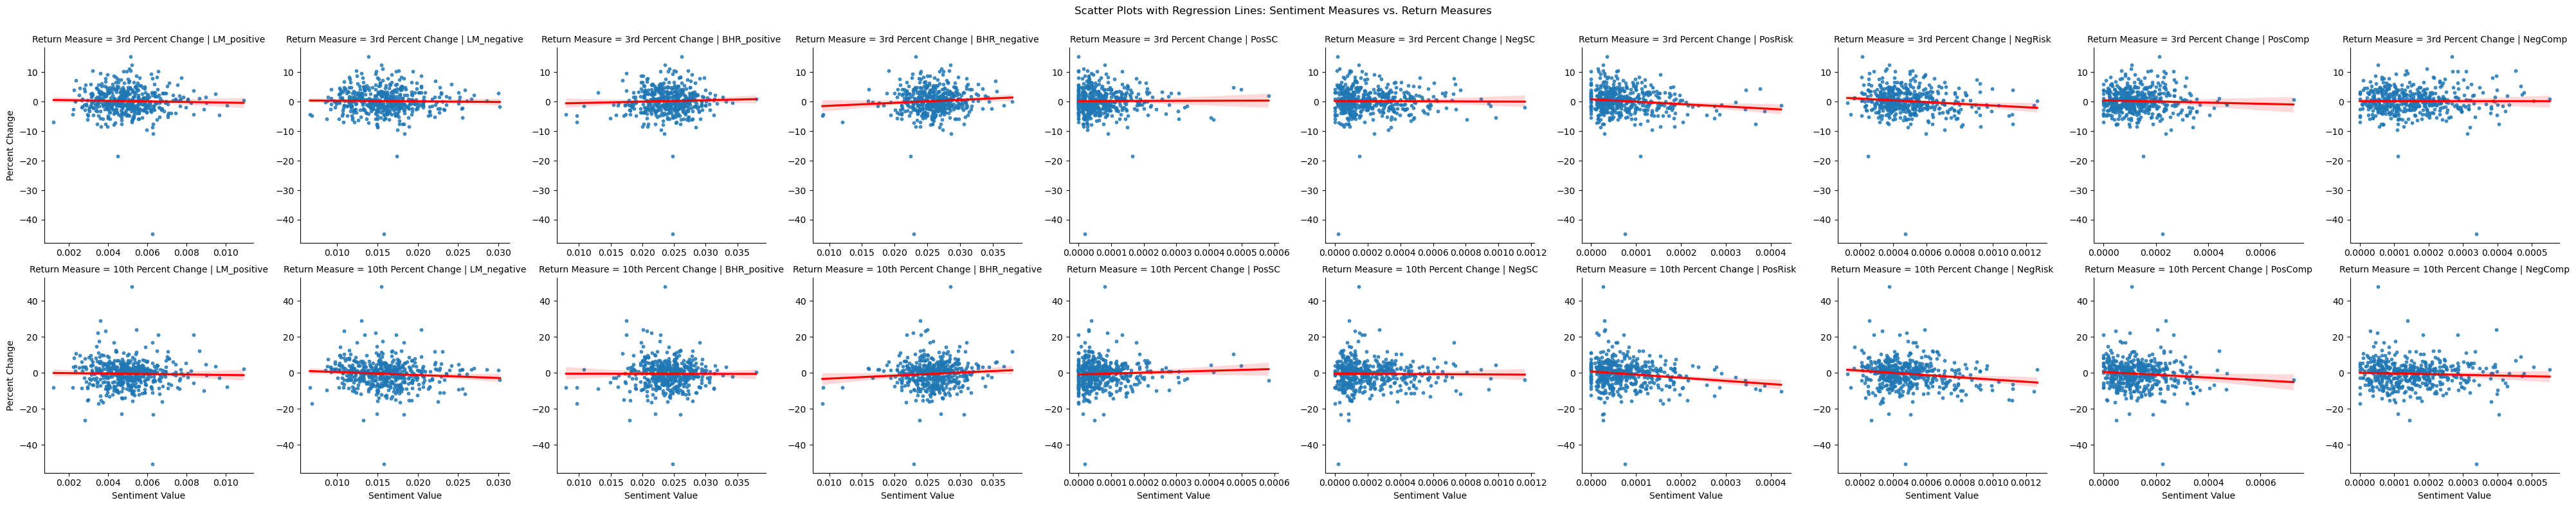

In [ ]:
#scatterplot with regression lines
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of all sentiment measures (5 positive and 5 negative)
sentiment_measures = ['LM_positive', 'LM_negative', 'BHR_positive', 'BHR_negative', 
                      'PosSC', 'NegSC', 'PosRisk', 'NegRisk', 'PosComp', 'NegComp']

# Create a long-form DataFrame for plotting
plot_data_3rd = merged_df.melt(
    id_vars=['Symbol', '3rd_Percent_Change'], value_vars=sentiment_measures, 
    var_name='Sentiment Measure', value_name='Sentiment Value'
)
plot_data_3rd['Return Measure'] = '3rd Percent Change'

plot_data_10th = merged_df.melt(
    id_vars=['Symbol', '10th_Percent_Change'], value_vars=sentiment_measures,
    var_name='Sentiment Measure', value_name='Sentiment Value'
)
plot_data_10th['Return Measure'] = '10th Percent Change'

# Combine the two datasets
plot_data = pd.concat([
    plot_data_3rd.rename(columns={'3rd_Percent_Change': 'Percent Change'}),
    plot_data_10th.rename(columns={'10th_Percent_Change': 'Percent Change'})
])

# Ensure 'Sentiment Value' and 'Percent Change' are numeric
plot_data['Sentiment Value'] = pd.to_numeric(plot_data['Sentiment Value'], errors='coerce')
plot_data['Percent Change'] = pd.to_numeric(plot_data['Percent Change'], errors='coerce')

# Drop rows with NaN values in these columns
plot_data = plot_data.dropna(subset=['Sentiment Value', 'Percent Change'])

# Create a FacetGrid for scatter plots with regression lines
g = sns.FacetGrid(
    plot_data, col='Sentiment Measure', row='Return Measure', sharex=False, sharey=False, height=4
)
# Map scatter plots with regression lines
g.map(sns.regplot, 'Sentiment Value', 'Percent Change', scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Add titles and adjust layout
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Sentiment Value', 'Percent Change')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scatter Plots with Regression Lines: Sentiment Measures vs. Return Measures')

# Show the plot
plt.show()
plot_data.to_csv('output/Regression_data.csv')